In [1]:
import keras
from keras import optimizers
from keras import losses
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Lambda, Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard
from keras.losses import mse, binary_crossentropy

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)



Using TensorFlow backend.


Python:  3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
pandas:  0.24.2
numpy:  1.16.3
seaborn:  0.9.0
matplotlib:  3.0.3
sklearn:  0.20.3
Keras:  2.2.4
Tensorflow:  1.13.1


In [2]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()


In [3]:
filePath = './creditcardanomalydetection.csv'
df = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=',')
print(df.shape[0])
df.head()


284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df0 = df.query('Class == 0').sample(20000)
df1 = df.query('Class == 1').sample(400)
df = pd.concat([df0, df1])

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(labels=['Time', 'Class'], axis = 1) , 
                                                    df['Class'], test_size=0.2, random_state=42)
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')


(16320, 29) train samples
(4080, 29) test samples


In [6]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [8]:
#variational autoencoder
logfilename = "variationalautoencoder"


original_dim  = x_train.shape[1]

print(original_dim)

input_shape = (original_dim,)
intermediate_dim = 12
batch_size = 32
latent_dim = 2
epochs = 20

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')


# VAE loss = mse_loss or xent_loss + kl_loss
reconstruction_loss = mse(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)





29
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 29)           0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 12)           360         encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            26          dense_4[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            26          dense_4[0][0]                    
__________________________________________________________________________________________________
z (Lamb

In [9]:
vae.compile(optimizer='adam', 
                    loss='mean_squared_error',
                    metrics=['accuracy'])
vae.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 29)                0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 412       
_________________________________________________________________
decoder (Model)              (None, 29)                413       
Total params: 825
Trainable params: 825
Non-trainable params: 0
_________________________________________________________________


In [10]:

history = vae.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[TensorBoard(log_dir='../logs/{0}'.format(logfilename))])


Instructions for updating:
Use tf.cast instead.
Train on 16320 samples, validate on 4080 samples
Epoch 1/20
16320/16320 [==============================] - 3s 202us/step - loss: 49.3899 - acc: 0.0994 - val_loss: 52.1579 - val_acc: 0.1865
Epoch 2/20
16320/16320 [==============================] - 3s 170us/step - loss: 45.4546 - acc: 0.1808 - val_loss: 51.3918 - val_acc: 0.1926
Epoch 3/20
16320/16320 [==============================] - 3s 172us/step - loss: 45.0209 - acc: 0.1936 - val_loss: 51.0406 - val_acc: 0.2174
Epoch 4/20
16320/16320 [==============================] - 3s 169us/step - loss: 44.7475 - acc: 0.2282 - val_loss: 50.7865 - val_acc: 0.2542
Epoch 5/20
16320/16320 [==============================] - 3s 161us/step - loss: 44.4994 - acc: 0.2600 - val_loss: 50.5697 - val_acc: 0.2826
Epoch 6/20
16320/16320 [==============================] - 3s 159us/step - loss: 44.3273 - acc: 0.2819 - val_loss: 50.4285 - val_acc: 0.2926
Epoch 7/20
16320/16320 [==============================] - 3s 17

In [32]:
score = vae.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4080/4080 [==============================] - 0s 60us/step
Test loss: 48.38297452739641
Test accuracy: 0.23529411764705882


In [22]:
threshold=10.00
y_pred = vae.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label=[]
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)



In [23]:
roc_auc_score(y_test, y_label)

0.9345736547003569

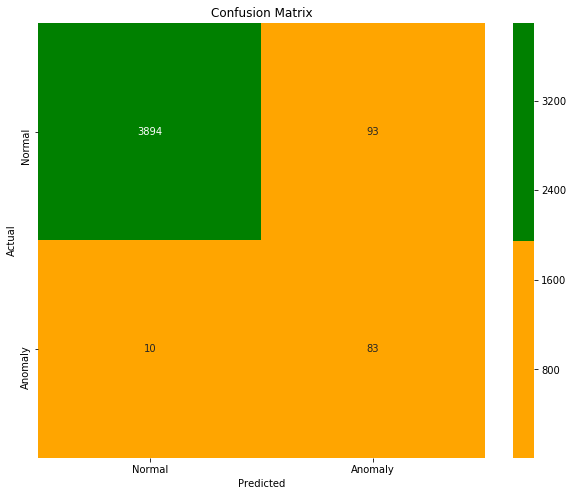

In [24]:
viz = Visualization()

viz.draw_confusion_matrix(y_test, y_label)

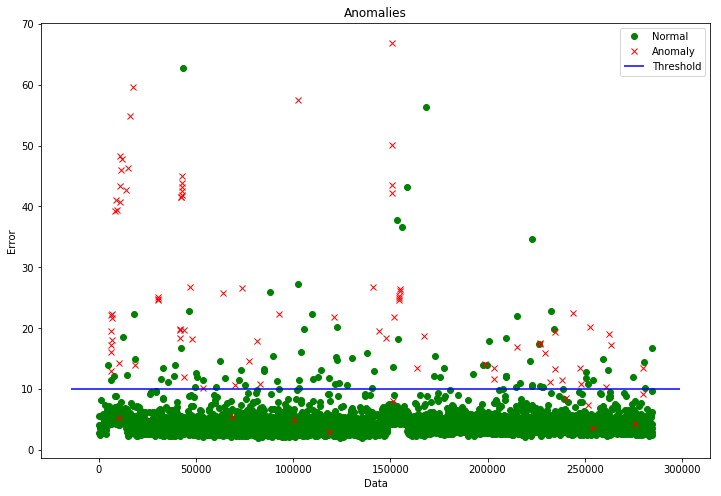

In [25]:
viz.draw_anomaly(y_test, error, threshold)